# Twitter Sentiment Analysis
---
## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [125]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AWM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\AWM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AWM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importing Data

In [58]:
def load_df(fp):
	df= pd.read_csv(fp, names=['id', 'ip', 'label', 'text']).set_index('id')
	df.drop_duplicates(inplace=True)
	df.dropna(inplace=True)
	df.info()
	return df

In [130]:
df_trn= load_df('twitter_training.csv')
print()
df_tst= load_df('twitter_validation.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 70958 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      70958 non-null  object
 1   label   70958 non-null  object
 2   text    70958 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3364 to 6960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      1000 non-null   object
 1   label   1000 non-null   object
 2   text    1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [131]:
df= pd.concat([df_trn, df_tst])

In [132]:
df.head()

,ip,label,text
id,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [133]:
df['label'].value_counts()

label
Negative      21831
Positive      19826
Neutral       17683
Irrelevant    12618
Name: count, dtype: int64

The target labels are somewhat balanced in their distribution. We will avoid `Irrelevant` and `Neutral` label for now. 

In [134]:
df= df[(df['label']!='Irrelevant')&(df['label']!='Neutral')]
df['label']= df['label'].map({'Positive': 1, 'Negative': 0}).astype('uint8')
df= df[['label', 'text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41657 entries, 2401 to 8069
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   41657 non-null  uint8 
 1   text    41657 non-null  object
dtypes: object(1), uint8(1)
memory usage: 691.6+ KB


In [135]:
df.head()

,label,text
id,,
2401,1,im getting on borderlands and i will murder yo...
2401,1,I am coming to the borders and I will kill you...
2401,1,im getting on borderlands and i will kill you ...
2401,1,im coming on borderlands and i will murder you...
2401,1,im getting on borderlands 2 and i will murder ...


## Preparing the Data

In [121]:
stop_words= set(stopwords.words('english'))

In [ ]:
def preprocess_data(data):
    processed_data= []
    for sentence, label in data:
        tokens= word_tokenize(sentence.lower())
        filtered_tokens= [word for word in tokens if word.isalnum() and word not in stop_words]
        processed_data.append((filtered_tokens, label))
    return processed_data

In [136]:
df_proc= preprocess_data(df[['text', 'label']].values)

In [137]:
df_proc

[(['im', 'getting', 'borderlands', 'murder'], 1),
 (['coming', 'borders', 'kill'], 1),
 (['im', 'getting', 'borderlands', 'kill'], 1),
 (['im', 'coming', 'borderlands', 'murder'], 1),
 (['im', 'getting', 'borderlands', '2', 'murder'], 1),
 (['im', 'getting', 'borderlands', 'murder'], 1),
 (['spent',
   'hours',
   'making',
   'something',
   'fun',
   'know',
   'huge',
   'borderlands',
   'fan',
   'maya',
   'one',
   'favorite',
   'characters',
   'decided',
   'make',
   'wallpaper',
   'pc',
   'original',
   'image',
   'versus',
   'creation',
   'made',
   'enjoy'],
  1),
 (['spent',
   'couple',
   'hours',
   'something',
   'fun',
   'know',
   'huge',
   'borderlands',
   'fan',
   'maya',
   'one',
   'favorite',
   'characters',
   'decided',
   'make',
   'wallpaper',
   'pc',
   'original',
   'picture',
   'compared',
   'creation',
   'made',
   'fun',
   'mlsi5wf9jg'],
  1),
 (['spent',
   'hours',
   'something',
   'fun',
   'know',
   'huge',
   'borderlands',


In [126]:
df_trn_proc= preprocess_data(df_trn[['text', 'label']].values)
df_tst_proc= preprocess_data(df_tst[['text', 'label']].values)

In [138]:
sentences= [tokens for tokens, label in df_trn_proc]
model= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [139]:
def sentence_vector(sentence):
    vector= np.zeros(100)
    count= 0
    for word in sentence:
        if word in model.wv:
            vector+= model.wv[word]
            count+= 1
    if count>0:
        vector/= count
    return vector

In [140]:
x= np.array([sentence_vector(tokens) for tokens, label in df_proc])
y= np.array([label for tokens, label in df_proc])

In [142]:
x

array([[ 0.61823526,  1.02517015, -0.11376363, ...,  0.55955121,
        -0.25652242, -0.3957788 ],
       [ 0.29713265,  0.75849257, -0.12789948, ...,  0.45817713,
        -0.13460552, -0.20146231],
       [ 0.64798961,  1.14590862, -0.11931136, ...,  0.64972115,
        -0.27693074, -0.44229535],
       ...,
       [ 0.30012794,  1.06778098, -0.22807091, ...,  0.44926638,
        -0.27594743, -0.33648879],
       [ 0.40939492,  0.92366667, -0.1262906 , ...,  0.57640069,
        -0.23829845, -0.30902485],
       [ 0.37495331,  0.63351461, -0.23637894, ...,  0.35261338,
         0.06502731, -0.14005316]])

In [152]:
x.shape

(41657, 100)

In [143]:
y

array([1, 1, 1, ..., 1, 1, 1])

## Data Split

In [144]:
x_trn, x_tst, y_trn, y_tst= train_test_split(x, y, test_size=0.2, random_state=42)

In [147]:
print(f'Train: {len(x_trn):5d} vectors, {len(y_trn):5d} labels')
print(f'Test:  {len(x_tst):5d} vectors, {len(y_tst):5d} labels')

Train: 33325 vectors, 33325 labels
Test:   8332 vectors,  8332 labels


## Models Training

Since our post-processed dataset became more digestible, consisting of just vectors of size 100 as input and a single binary output value, we could use traditional Machine Learning algorithms which will perform well on this structured data

In [148]:
def model_report(model, verbose=True):
	model.fit(x_trn, y_trn)

	y_pred=   model.predict(x_tst)
	trnScore= model.score(x_trn, y_trn)
	tstScore= model.score(x_tst, y_tst)
	cm= confusion_matrix(y_tst, y_pred)
	cr= classification_report(y_tst, y_pred)

	if verbose:
		print('Train Score: %f'%trnScore)
		print('Test Score:  %f'%tstScore)
		print('Classification Report:\n', cr)
		ConfusionMatrixDisplay(cm).plot()
		plt.show()
		print()
	
	return {
		'trn': trnScore,
		'tst': tstScore,
		'cm':  cm,
		'cr':  cr,
	}

In [149]:
models_dict= {
	'LogisticRegression':     LogisticRegression(max_iter=10_000),
	'Support Vector':         SVC(),
	'KNeighborsCLassifier':   KNeighborsClassifier(),
	'DecisionTreeClassifier': DecisionTreeClassifier(),
	'RandomForestClassifier': RandomForestClassifier(),
	'BaggingClassifier':      BaggingClassifier(),
	'ExtraTreesClassifier':   ExtraTreesClassifier(),
	'AdaBoostClassifier':     AdaBoostClassifier(),
	'XGBClassifier':          XGBClassifier(),
	'CatBoostClassifier':     CatBoostClassifier(verbose=False),
	'LGBMClassifier':         LGBMClassifier(),
}
models= [{'name':k, 'obj':v} for k,v in models_dict.items()]

i= 0
for model in models:
	print("Evaluating %s..."%model['name'])
	print("%d/%d models"%(i, len(models)), end='\r')
	model.update(model_report(model['obj'], verbose=False))
	i+= 1
print("%d/%d models evaluated"%(i, len(models)))
print("done")

Evaluating LogisticRegression...
Evaluating Support Vector...
Evaluating KNeighborsCLassifier...
Evaluating DecisionTreeClassifier...
Evaluating RandomForestClassifier...
Evaluating BaggingClassifier...
Evaluating ExtraTreesClassifier...
Evaluating AdaBoostClassifier...


d:\Programs\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Evaluating XGBClassifier...
Evaluating CatBoostClassifier...
Evaluating LGBMClassifier...
[LightGBM] [Info] Number of positive: 15884, number of negative: 17441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 33325, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476639 -> initscore=-0.093511
[LightGBM] [Info] Start training from score -0.093511
11/11 models evaluated
done


## Models Evaluation

In [150]:
pd.DataFrame({
	'Algorithm':           [model['name'] for model in models],
	'Train Score':         [model['trn']  for model in models],
	'Test Score':          [model['tst']  for model in models],
}).set_index('Algorithm').sort_values(by='Test Score', ascending=False)

,Train Score,Test Score
Algorithm,,
ExtraTreesClassifier,0.987187,0.864978
RandomForestClassifier,0.987187,0.859578
KNeighborsCLassifier,0.900975,0.842775
XGBClassifier,0.951118,0.835214
BaggingClassifier,0.979625,0.823452
CatBoostClassifier,0.886182,0.816971
LGBMClassifier,0.837329,0.791767
DecisionTreeClassifier,0.987187,0.772564
Support Vector,0.770953,0.765362


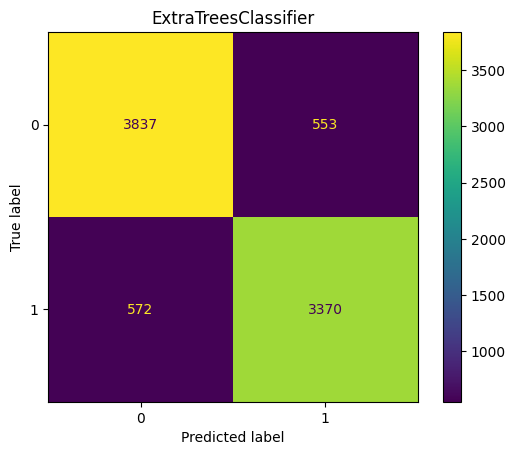

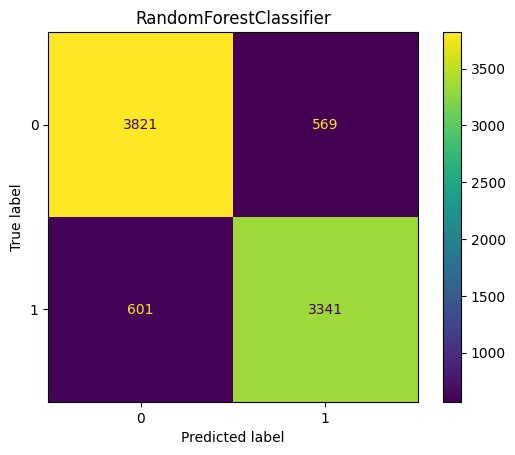

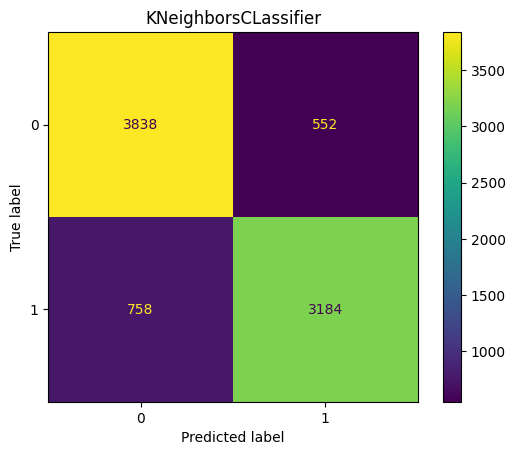

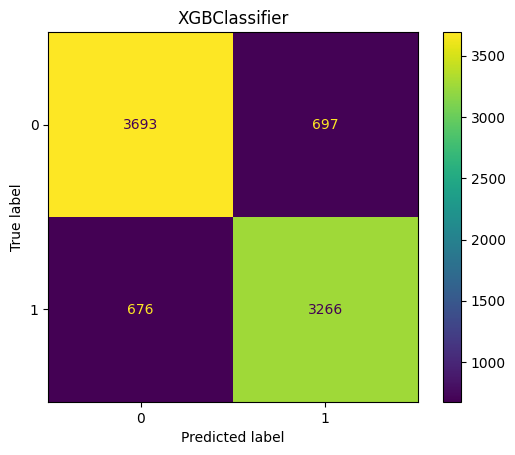

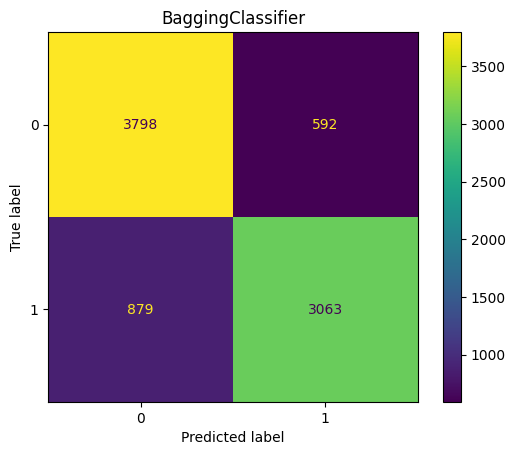

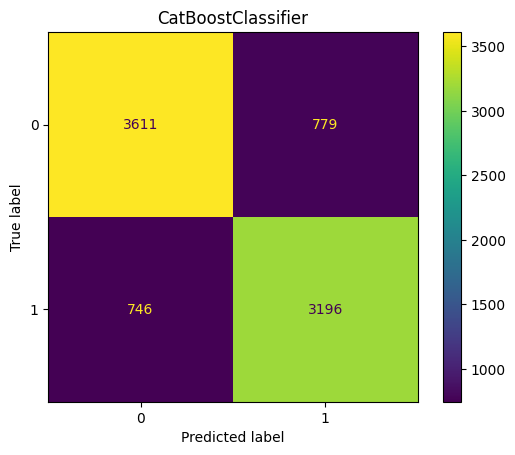

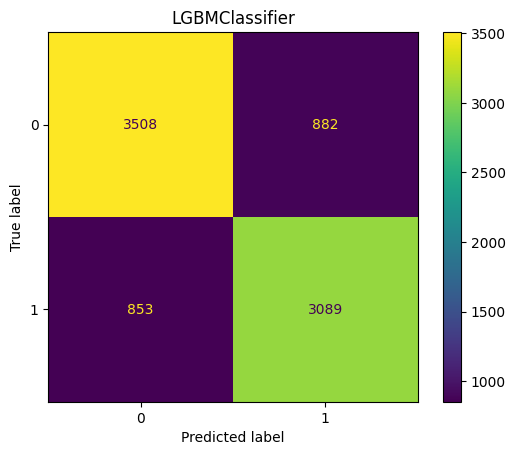

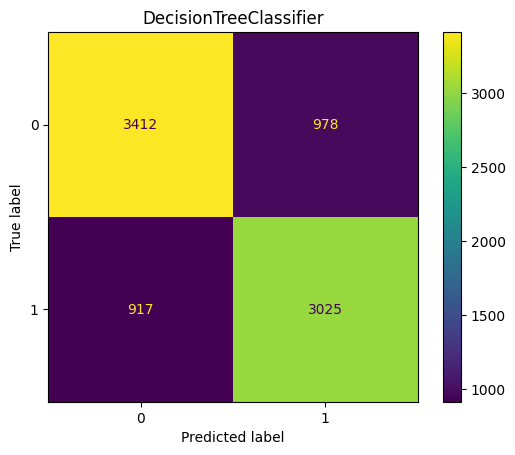

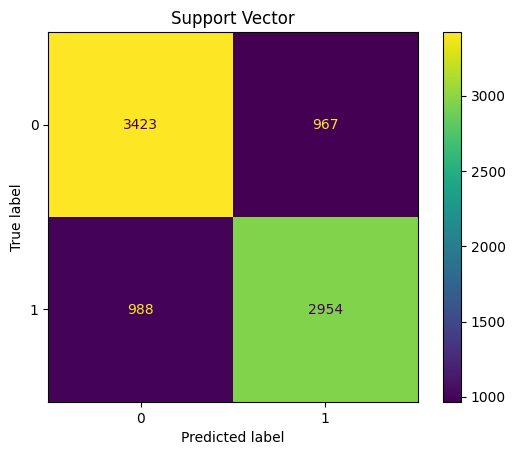

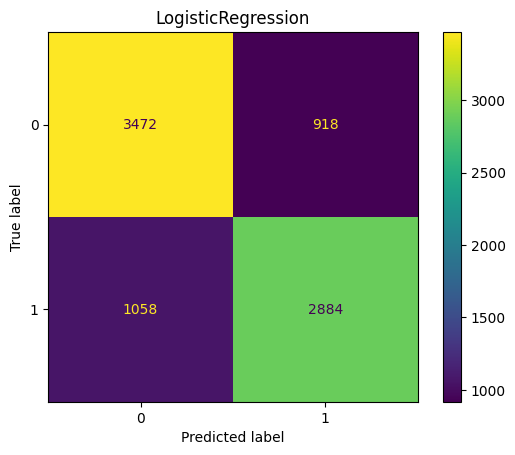

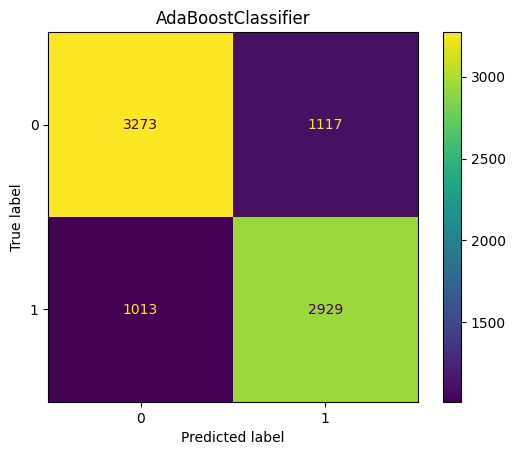

In [151]:
for model in sorted(models, key=lambda x: x['tst'], reverse=True):
	ConfusionMatrixDisplay(model['cm']).plot()
	plt.title(model['name'])